In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %cd /content/drive/MyDrive/NNFL_Assignment_2/

In [ ]:
# !sudo unzip -q nnfl-2021-assignment-2.zip

# Imports

In [ ]:
import csv
import time
import gc
import numpy as np
import cv2
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from tensorflow.keras import layers, Model
from keras.regularizers import l2

In [ ]:
def custom_set_seed(x):
  tf.random.set_seed(x)
  random.seed(x)
  np.random.seed(x)

In [ ]:
custom_set_seed(0)

# Loading Data

In [ ]:
s = time.time()

train_vid_names = []
train_vid_label = []

train_csv = open('/content/drive/MyDrive/NNFL_Assignment_2/train.csv')
reader = csv.DictReader(train_csv)

for row in reader:
    train_vid_names.append(row['File'])
    train_vid_label.append([1,0] if row['True_Label']=='fire' else [0,1])
    
train_csv.close()
train_vid_label = np.array(train_vid_label)
e = time.time()
print(e-s)

0.025763988494873047


In [ ]:
from tqdm.auto import tqdm

In [ ]:
max_frames = 120
frame_size = (128, 128)

frames = np.zeros((len(train_vid_names), max_frames, frame_size[0], frame_size[1], 3), dtype=np.float32)
frame_count = []
train_folder = '/content/drive/MyDrive/NNFL_Assignment_2/train/'

print(sys.getsizeof(frames))
gc.collect()

s = time.time()

for i in tqdm(range(len(train_vid_names))):
    
    vid = cv2.VideoCapture(train_folder+train_vid_names[i])
    
    
    # Load full video in temp
    temp = [] 
    ret, frame = vid.read()
    while ret:
        temp.append(cv2.resize(frame,frame_size))
        ret, frame = vid.read()
     
    length = len(temp)
    
    if length < max_frames:
        
        pads_required = max_frames % length
        each_frame_multiplicity = max_frames // length
        for _ in range(len(temp)):
            for __ in range(each_frame_multiplicity):
                frames[i][pads_required + _*each_frame_multiplicity + __] = temp[_]
    else:
        
        jump = length / max_frames
        for _ in range(max_frames):
            frames[i][_] = temp[int(_*jump)]
    # print(i)
    frame_count.append(frames[i].shape)
    gc.collect()

e = time.time()
print(e-s)

2831155360


  0%|          | 0/120 [00:00<?, ?it/s]

135.59601950645447


In [ ]:
gc.collect()

531

# Model

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for i in gpus:
    print(i)
    tf.config.experimental.set_memory_growth(i, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape = (max_frames, frame_size[0], frame_size[1], 3)))

model.add(layers.TimeDistributed(layers.Conv2D(12, (3, 3), activation='relu')))
model.add(layers.TimeDistributed(layers.Conv2D(25, (3, 3), activation='relu')))
model.add(layers.TimeDistributed(layers.Conv2D(50, (3, 3), activation='relu')))
model.add(layers.TimeDistributed(layers.MaxPool2D()))

model.add(layers.TimeDistributed(layers.Conv2D(75, (3, 3), activation='relu')))
model.add(layers.TimeDistributed(layers.MaxPool2D()))

model.add(layers.TimeDistributed(layers.Conv2D(100, (3, 3), activation='relu')))
model.add(layers.TimeDistributed(layers.MaxPool2D()))

model.add(layers.TimeDistributed(layers.Conv2D(128, (3, 3), activation='relu')))
model.add(layers.TimeDistributed(layers.MaxPool2D()))

model.add(layers.TimeDistributed(layers.Conv2D(256, (3, 3), activation='relu')))
model.add(layers.TimeDistributed(layers.MaxPool2D()))

model.add(layers.TimeDistributed(layers.Flatten()))

model.add(layers.LSTM(25, return_sequences=False,
                      kernel_regularizer=l2(0.01),
                      recurrent_regularizer=l2(0.01),
                      bias_regularizer=l2(0.01)
                      ))

model.add(layers.Dense(75, activation='relu'))
model.add(layers.Dropout(0.1))

model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(0.15))

model.add(layers.Dense(25, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(2, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 120, 126, 126, 12  336      
 ibuted)                     )                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 120, 124, 124, 25  2725     
 tributed)                   )                                   
                                                                 
 time_distributed_2 (TimeDis  (None, 120, 122, 122, 50  11300    
 tributed)                   )                                   
                                                                 
 time_distributed_3 (TimeDis  (None, 120, 61, 61, 50)  0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 120, 59, 59, 75)  3

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(frames, train_vid_label, test_size=0.2, shuffle=True)
# the_model.fit(x=x_train, y=y_train, batch_size=64, epochs=100, validation_data=(x_val, y_val))

# Training the model

In [ ]:
gc.collect()

3695

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
                loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(x=x_train, y=y_train, batch_size = 3, epochs = 100, validation_data=(x_valid, y_valid))

Epoch 1/100
32/32 [==============================] - 54s 1s/step - loss: 2.6113 - accuracy: 0.4062 - val_loss: 2.5270 - val_accuracy: 0.5833
Epoch 2/100
32/32 [==============================] - 35s 1s/step - loss: 2.5084 - accuracy: 0.5000 - val_loss: 2.4404 - val_accuracy: 0.5833
Epoch 3/100
32/32 [==============================] - 34s 1s/step - loss: 2.3805 - accuracy: 0.6250 - val_loss: 2.3561 - val_accuracy: 0.4583
Epoch 4/100
32/32 [==============================] - 34s 1s/step - loss: 2.3457 - accuracy: 0.4062 - val_loss: 2.2741 - val_accuracy: 0.5833
Epoch 5/100
32/32 [==============================] - 34s 1s/step - loss: 2.2505 - accuracy: 0.4479 - val_loss: 2.2001 - val_accuracy: 0.5417
Epoch 6/100
32/32 [==============================] - 35s 1s/step - loss: 2.1833 - accuracy: 0.4896 - val_loss: 2.1295 - val_accuracy: 0.5833
Epoch 7/100
32/32 [==============================] - 34s 1s/step - loss: 2.1041 - accuracy: 0.4896 - val_loss: 2.0618 - val_accuracy: 0.5833
Epoch 8/100
3

# Plots

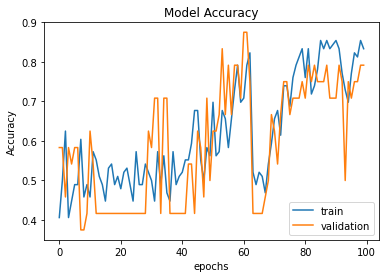

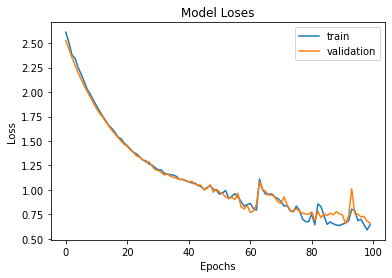

7138

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc = 'lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc = 'upper right')
plt.show()

gc.collect()

In [ ]:
model.save('/content/drive/MyDrive/NNFL_Assignment_2/saved_model_v2/')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/NNFL_Assignment_2/saved_model_v2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/NNFL_Assignment_2/saved_model_v2/assets


# Generating Submission.csv

In [ ]:
gc.collect()

111306

In [ ]:
s = time.time()

test_vid_names = []
test_vid_label = []

test_csv = open('/content/drive/MyDrive/NNFL_Assignment_2/test.csv')
reader = csv.DictReader(test_csv)

for row in reader:
  test_vid_names.append(row['File'])
    
test_csv.close()
test_vid_label = np.array(test_vid_label)
e = time.time()
print(e-s)
gc.collect()

0.48032474517822266


131

In [ ]:
frames_t = np.zeros((len(test_vid_names), max_frames, frame_size[0], frame_size[1], 3), dtype=np.float32)
frame_count_t = []
test_folder = '/content/drive/MyDrive/NNFL_Assignment_2/test/'

print(sys.getsizeof(frames))
gc.collect()

s = time.time()

for i in tqdm(range(len(test_vid_names))):
    
    vid = cv2.VideoCapture(test_folder+test_vid_names[i])
    
    
    # Load full video in temp
    temp = [] 
    ret, frame = vid.read()
    while ret:
        temp.append(cv2.resize(frame,frame_size))
        ret, frame = vid.read()
     
    length = len(temp)
    
    if length < max_frames:
        
        pads_required = max_frames % length
        each_frame_multiplicity = max_frames // length
        for _ in range(len(temp)):
            for __ in range(each_frame_multiplicity):
                frames_t[i][pads_required + _*each_frame_multiplicity + __] = temp[_]
    else:
        
        jump = length / max_frames
        for _ in range(max_frames):
            frames_t[i][_] = temp[int(_*jump)]
    frame_count_t.append(frames[i].shape)
    gc.collect()

e = time.time()
print(e-s)

gc.collect()

2831155360


  0%|          | 0/20 [00:00<?, ?it/s]

32.74474287033081


0

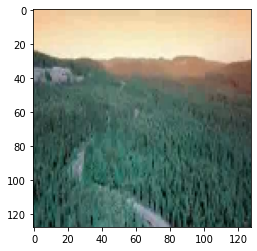

In [ ]:
x = np.array(frames_t[0][119], dtype=np.int)
plt.imshow(x)

In [ ]:
s = time.time()
output = model.predict(frames_t)
e = time.time()
print(e-s)

test_vid_label = []
for i in output:
    test_vid_label.append('fire' if i[0]>0.5 else 'not_fire')

ResourceExhaustedError: ignored

In [ ]:
!touch Submission.csv

open('Submission.csv', 'w').close()

output = open('Submission.csv', 'w')

header = ['File', 'Label']
writer = csv.writer(output)
writer.writerow(header)

for i in range(len(test_vid_names)):
    writer.writerow([test_vid_names[i],test_vid_label[i]])

output.close()